In [1]:
import re
import seaborn as sns
import xgboost as xgb
import pandas as pd
import numpy as np
import sklearn.model_selection as ms
import sklearn.preprocessing as pp
import sklearn.feature_selection as fs
from sklearn.cross_validation import StratifiedKFold
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import validation_curve


import matplotlib.pylab as plt
from features1 import add_title,fill_age,fill_fare,fill_embarked,fill_cabin,fill_ticket,add_family

seed = 9497

/home/wing/.virtualenvs/cv/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/home/wing/.virtualenvs/cv/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/wing/.virtualenvs/cv/local/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes a

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
total=pd.concat([train,test])
PassengerId=total['PassengerId']

In [3]:
# Add title, drop name, add family
total=add_title(total)
total.drop('Name',axis=1,inplace=True)# Fill
total=add_family(total)

In [4]:
# Fill age, fare, embarked
total=fill_age(total)
total=fill_fare(total)
total=fill_embarked(total)
total=fill_cabin(total)
total=fill_ticket(total)

/home/wing/.virtualenvs/cv/local/lib/python2.7/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/wing/.virtualenvs/cv/local/lib/python2.7/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
features1.py:113: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  df['TicketNum'] = df['TicketNum'].convert_objects(convert_numeric=True)


In [5]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 18 columns):
Age            1309 non-null float64
Cabin          1309 non-null object
Embarked       1309 non-null object
Fare           1309 non-null float64
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Title          1309 non-null object
FamilySize     1309 non-null int64
Singleton      1309 non-null int64
SmallFamily    1309 non-null int64
LargeFamily    1309 non-null int64
TicketAlpha    1309 non-null object
TicketNum      1305 non-null float64
dtypes: float64(4), int64(8), object(6)
memory usage: 194.3+ KB


In [6]:
# Turn binary (titles) 
total = pd.concat([total,pd.get_dummies(total['Title'],prefix='Title')],axis=1)
total = pd.concat([total,pd.get_dummies(total['Embarked'],prefix='Embarked')],axis=1)
total = pd.concat([total,pd.get_dummies(total['Cabin'], prefix='Cabin')], axis=1)
total = pd.concat([total,pd.get_dummies(total['Pclass'], prefix="Pclass")],axis=1) 
total['Sex'] = total['Sex'].map({'male':1,'female':0})
total = pd.concat([total, pd.get_dummies(total['Ticket'], prefix='Ticket')], axis=1)


In [7]:
# Drop
total.drop('Title',axis=1,inplace=True)
total.drop('Embarked',axis=1,inplace=True)
total.drop('Cabin', axis=1, inplace=True)
total.drop('Pclass',axis=1,inplace=True)
total.drop('Ticket', inplace=True, axis=1)
total.drop('PassengerId', inplace=True, axis=1)
total.drop('Survived', axis=1, inplace=True)

In [8]:
data_y=train['Survived']
data_x=total.iloc[range(len(data_y))]
test_x=total.iloc[len(data_y):]



In [9]:
cv_params = {
#    'learning_rate':[0.05,0.1,0.2],
#    'subsample':[0.7,0.8,0.9]
#    'max_depth':range(8),
#    'min_child_weight':range(6),
#    'colsample_bytree':[0.7,0.8,0.9],
}
fixed_params = {
    'max_depth':2,
    'min_chil_weight':1,
    'learning_rate':0.1,
    'n_estimators':1000,
    'random_state':seed,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'objective':'binary:logistic',
}

optimized_gbm = GridSearchCV(xgb.XGBClassifier(**fixed_params),
                            cv_params,
                            scoring='accuracy',
                            cv=5,
                            n_jobs=-1)



In [9]:
optimized_gbm.fit(data_x,data_y)

NameError: name 'optimized_gbm' is not defined

In [11]:
optimized_gbm.grid_scores_
#optimized_gbm.best_params_

[mean: 0.84848, std: 0.02218, params: {}]

SyntaxError: invalid syntax (<ipython-input-1-b9dd21190486>, line 28)

In [13]:
xgb_params = {
    'learning_rate':0.1,
    'random_state':seed,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'objective':'binary:logistic',
    'max_depth':2,
    'min_child_weight':1,
}
final_xgb = xgb.train(xgb_params, xgb_matrix, num_boost_round = 223)

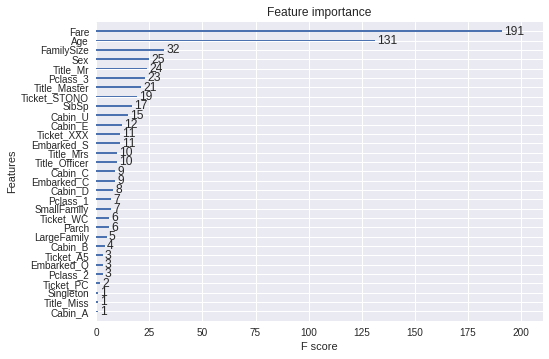

In [14]:
xgb.plot_importance(final_xgb)
plt.show()

In [72]:
xgb_params = {
    'learning_rate':0.1,
    'random_state':seed,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'objective':'binary:logistic',
    'max_depth':2,
    'min_child_weight':1,
    'n_estimators':223,
}
est_range = [i for i in range(10)]

train_scores, test_scores = validation_curve(xgb.XGBClassifier(**xgb_params),
                                             data_x,
                                             data_y,
                                             param_name = 'max_depth',
                                             param_range = est_range,
                                             cv=5,
                                             scoring='accuracy')

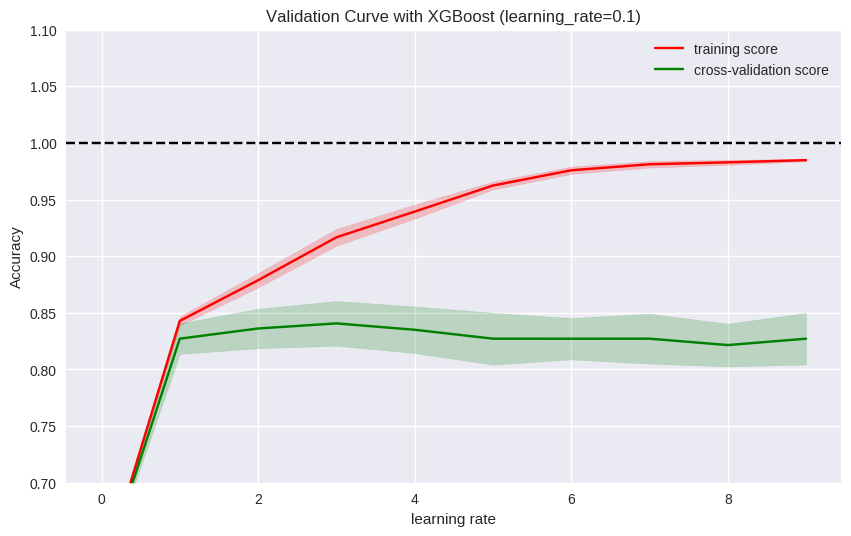

In [73]:
train_sm = np.mean(train_scores, axis=1)
train_ss = np.std(train_scores, axis=1)
test_sm = np.mean(test_scores, axis=1)
test_ss = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10,6), dpi=100)

plt.title("Validation Curve with XGBoost")
plt.xlabel('Parameter')
plt.ylabel('Accuracy')
plt.ylim(0.7,1.1)

plt.plot(est_range, train_sm, label='training score', color='r')
plt.plot(est_range, test_sm, label='cross-validation score', color='g')
plt.fill_between(est_range, train_sm-train_ss, train_sm+train_ss, alpha=0.2, color='r')
plt.fill_between(est_range, test_sm-test_ss, test_sm+test_ss, alpha=0.2, color='g')

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc='best')
plt.show()

In [16]:
xgb_params = {
    'learning_rate':0.1,
    'random_state':seed,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'objective':'binary:logistic',
    'max_depth':2,
    'min_child_weight':1,
    'n_estimator':223
}
xgb_matrix=xgb.DMatrix(data_x, label=data_y)
xgb_cv = xgb.cv(params=xgb_params,
                dtrain= xgb_matrix,
                num_boost_round=3000,
                nfold=5,
                metrics = ['auc','error'],
                early_stopping_rounds=100,
#                stratified=True,
#                verbose_eval=1,
               )


model = xgb.XGBClassifier(**xgb_params)
model.fit(data_x,data_y)
test_predictions = model.predict(test_x)
submission = pd.DataFrame({ 'PassengerId': test['PassengerId'],
                            'Survived': test_predictions })
submission.to_csv("submission.csv", index=False)
xgb_cv.tail(5)

,test-auc-mean,test-auc-std,test-error-mean,test-error-std,train-auc-mean,train-auc-std,train-error-mean,train-error-std
219,0.881429,0.029387,0.169663,0.022584,0.937817,0.004467,0.114888,0.003597
220,0.881700,0.029442,0.170786,0.022075,0.937832,0.004551,0.114607,0.003276
221,0.881564,0.029588,0.170786,0.021496,0.937787,0.004632,0.114045,0.003810
222,0.881152,0.029578,0.170786,0.021496,0.938046,0.004543,0.114607,0.004833
223,0.880948,0.029679,0.168539,0.023835,0.938146,0.004590,0.114326,0.004833
